I tried M5 forecast predicsion.This is my 2nd submission.<br>
The difference from the previous time is that the data shape of the training model was changed, not only the lag feature amount but also the date and the price feature amount were added, and from the EDA result, the category according to the lag value narrowing and the volume This is the point where variables are added.

Previous kernel<br>
1st submission<br>
https://www.kaggle.com/urayukitaka/m5-forecasting-eda-and-lgbm-prediction<br>
EDA<br>
https://www.kaggle.com/urayukitaka/eda-of-m5-forecast-data-categorical-and-timeserie

## Libraries

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import time
import datetime
import gc

# Data preprocessing
import category_encoders as ce
from sklearn.model_selection import train_test_split

# LightGBM
import lightgbm as lgb

# Validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Data loading

In [ ]:
# load master data
train = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
price = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
sample = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")

In [ ]:
# for submisson data
valid_df = pd.DataFrame(np.array(train.iloc[:,-28:])).astype("int16")

## Data preprocessing

Direction

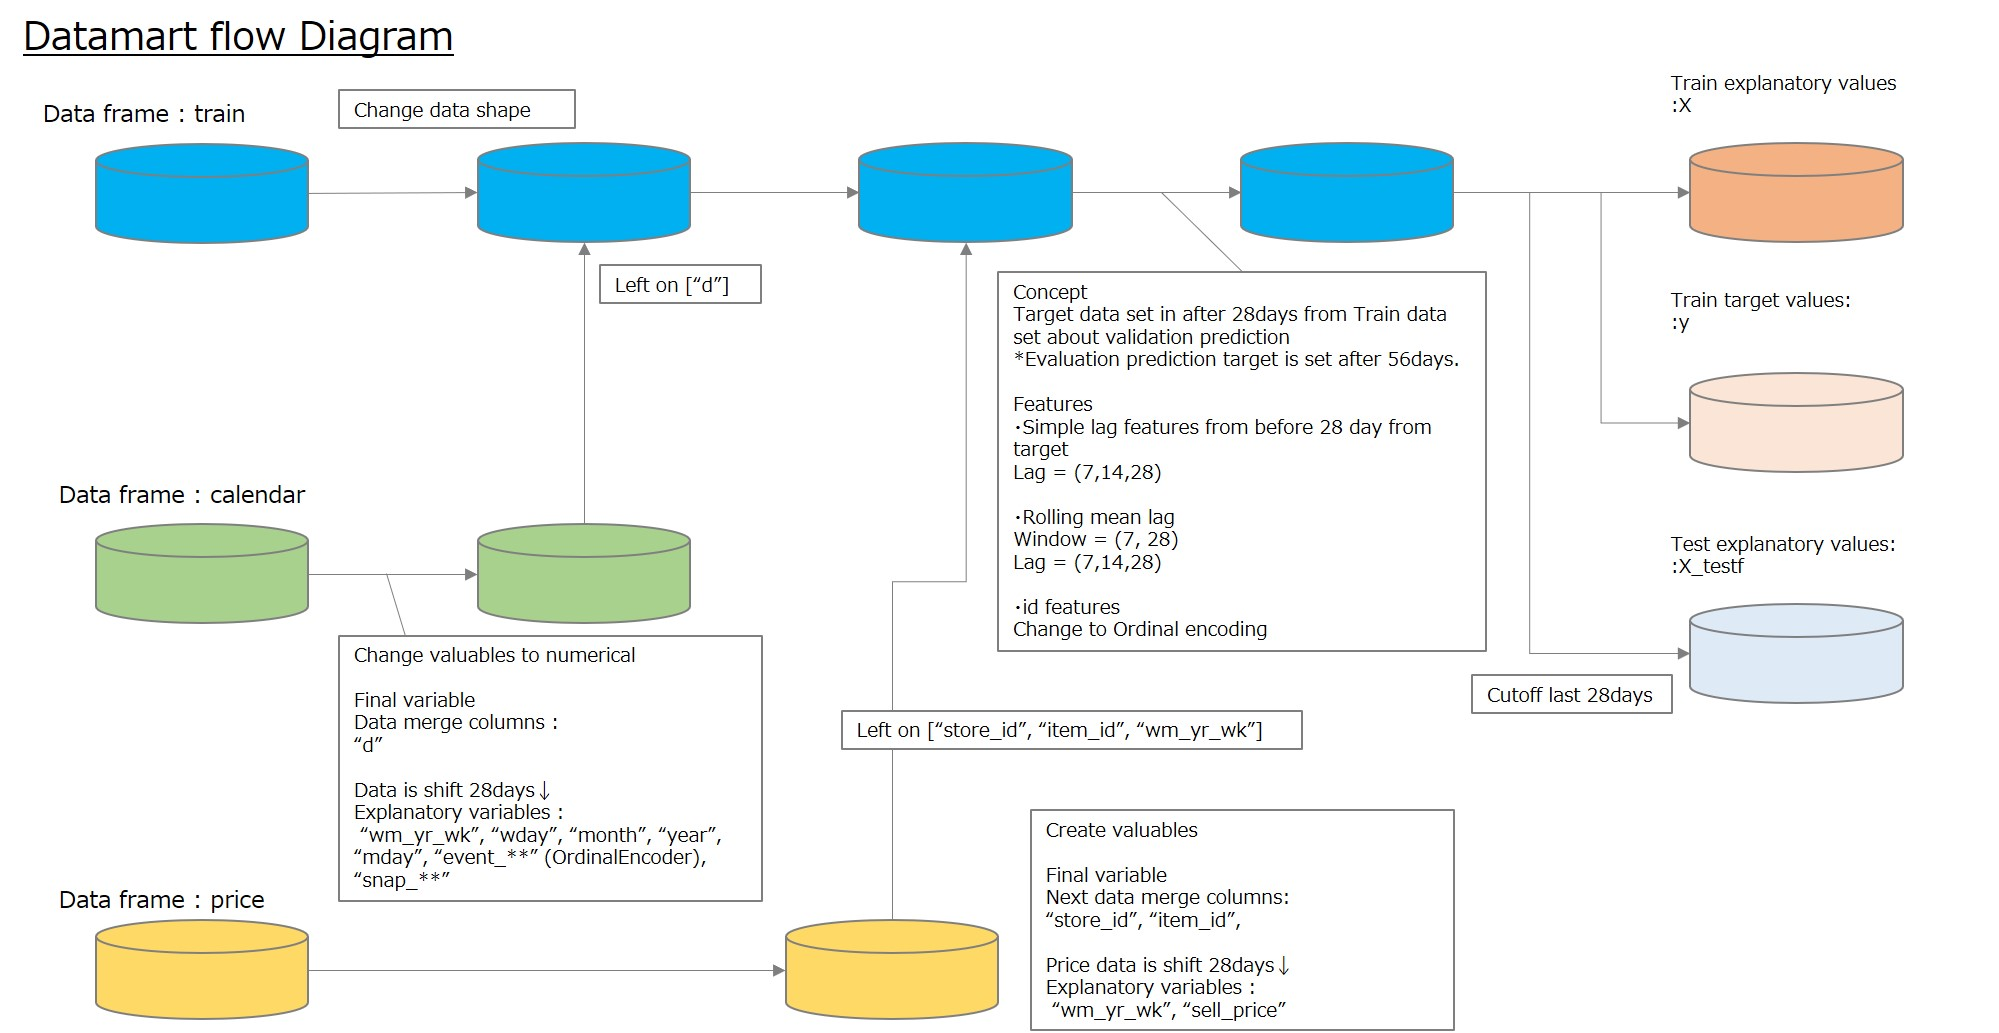

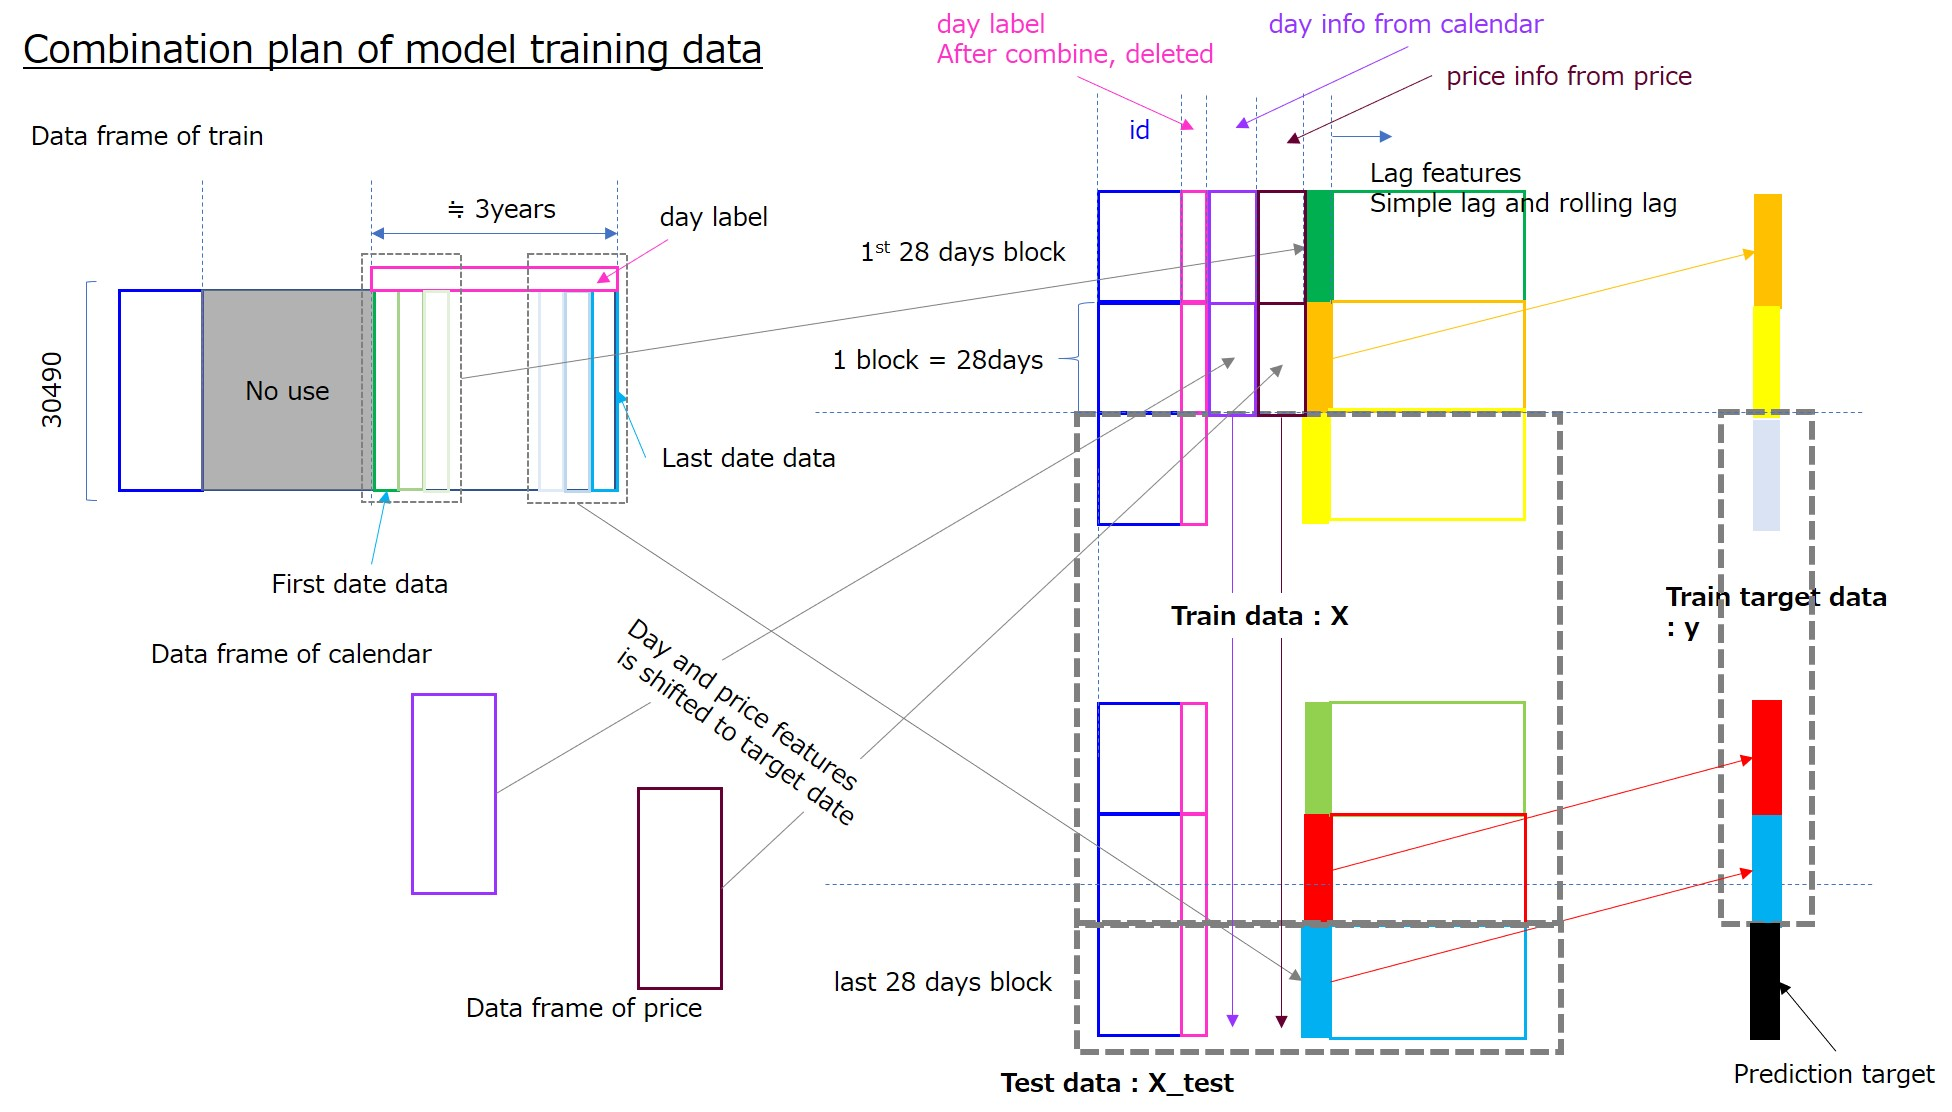

Define functions

In [ ]:
def calendar_preprocessing(df=calendar):
    # int_col, change to light
    int16_col = ["wm_yr_wk", "wday", "month", "year", "snap_CA", "snap_TX", "snap_WI"]
    df[int16_col] = df[int16_col].astype("int16")
    
    # dtype of date is changed datetime64
    df["date"] = pd.to_datetime(df["date"])
    # create month of day 
    df["mday"] = df["date"].dt.day.astype("int8")
    
    # OrdinalEncoding
    # event object to numerical, ordinal encoder
    list_col = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
    # fill na by str 'no'
    df[list_col] = df[list_col].fillna("na")
    # Roop 
    for i in list_col:
        ce_oe = ce.OrdinalEncoder(cols=i, handle_unknown='impute') # Create instance of OrdinalEncoder
        df = ce_oe.fit_transform(df)
        df[i] = df[i].astype("int16") # change to light dtype
        
    # shift 28days
    col = ['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 
           'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI','mday']
    # Roop
    for c in col:
        df['shift28_{}'.format(c)] = df[c].shift(-28).fillna(1000).astype("int16") # tempolary na is filled 1000

    # Drop unnecessaly columns
    df.drop(col, axis=1, inplace=True)
    # drop weekday columns
    df.drop("weekday", axis=1, inplace=True)
    # * for memory drop not important column
    df.drop(["shift28_event_type_1", "shift28_event_name_2", "shift28_event_type_2"], axis=1, inplace=True)

    return df

def price_preprocessing(df=price):
    # int_col, change to light
    int16_col = ["wm_yr_wk"]
    df[int16_col] = df[int16_col].astype("int16")
    float16_col = ["sell_price"]
    df[float16_col] = df[float16_col].astype("float16")
    
    # shift 28days to upward
    col = ['wm_yr_wk', 'sell_price']
    df['shift28_{}'.format(col[0])] = df[col[0]].shift(-28).fillna(1000).astype("int16") # tempolary na is filled 1000
    df['shift28_{}'.format(col[1])] = df[col[1]].shift(-28).fillna(1000).astype("float16") # tempolary na is filled 1000
        

    # Drop unnecessaly columns
    df.drop(col, axis=1, inplace=True)
    
    return df

def train_preprocessing(df=train):
    # int_col, change to light
    int16_col = df.loc[:,"d_1":].columns
    # dtype change
    df[int16_col] = df[int16_col].astype("int16")
    
    # for memory and light calculation, date range change to 3years, first date flag is d_818
    drop_col = df.loc[:,"d_1":"d_817"]
    df.drop(drop_col, axis=1, inplace=True)
    
    # change shape to vertical
    id_col = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    df = df.melt(id_vars=id_col, var_name="d", value_name="volume")

    return df

In [ ]:
# exe calendar data preprocessing
calendar = calendar_preprocessing(df=calendar)
calendar.dtypes

In [ ]:
# exe price data preprocessing
price = price_preprocessing(df=price)
price.dtypes

In [ ]:
# exe train data preprocessing
train = train_preprocessing(df=train)
train.dtypes

In [ ]:
# data merge
# train + calendar
master = pd.merge(train, calendar, left_on="d", right_on="d", how="left")

# master + price
master = pd.merge(master, price, left_on=["store_id", "item_id", "shift28_wm_yr_wk"],
                      right_on=["store_id", "item_id", "shift28_wm_yr_wk"], how='left')

In [ ]:
del train, calendar, price
gc.collect()

In [ ]:
# Data preprocessing and create trainig data and validation data and test data

# 1) id_col change to light by changing numerical int columns
# 2) drop "d" columns
# 3) create lag features of volume
# 3-1) lag 7 and 14 and 28, lag features is change difference from latest volume
# 3-2) Rolling mean window is (7,28)
# 4) Drop noise date, Xmas
# 5) Special features
# 6) target data

def Create_train_test_dataset(df=master, random_state=10):
    # 0, No data of sell_price value is dropped
    df.dropna(inplace=True)
    # 1)
    id_col = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    for i in id_col:
        ce_oe = ce.OrdinalEncoder(cols=i, handle_unknown='impute') # Create instance of OrdinalEncoder
        df = ce_oe.fit_transform(df)
        df[i] = df[i].astype("int16") # change to light dtype
    ###########################################################
    # 2)
    df.drop("d", axis=1, inplace=True)
    ###########################################################
    # 3-1)
    lags = [7, 14, 28]
    for l in lags: # tempolary fillna by 1000
        df["lag_{}".format(l)] = df.groupby("id")["volume"].transform(lambda x: x.shift(l)).fillna(1000).astype("int16")
        df["lag_d_{}".format(l)] = df.groupby("id")["volume"].transform(lambda x: x.shift(l) - x.shift(0)).fillna(1000).astype("int16")
    ###########################################################
    # 3-2)    
    window = [7,28]
    for w in window:# tempolary fillna by 1000
        for l in lags:
            df["rolling_{}_lag_{}".format(w,l)] = df.groupby("id")["volume"].transform(lambda x: x.rolling(w).mean().shift(l)).fillna(1000).astype("float16")
            df["rolling_{}_lag_d_{}".format(w,l)] = df.groupby("id")["volume"].transform(lambda x: x.rolling(w).mean().shift(l) - x.rolling(w).mean().shift(0)).fillna(1000).astype("float16")
    ###########################################################
    # 5-1) 
    # volume range
    list_vol_flag = []
    for v in df["volume"]:
        if v == 0:
            flg = 0
            list_vol_flag.append(flg)
        elif v == 1:
            flg = 1
            list_vol_flag.append(flg)
        elif v == 2:
            flg = 2
            list_vol_flag.append(flg)
        elif v > 2 and v <= 5:
            flg = 3
            list_vol_flag.append(flg)
        elif v > 5 and v <=20:
            flg = 4
            list_vol_flag.append(flg)
        else :
            flg=5
            list_vol_flag.append(flg)
    df["vol_range"] = list_vol_flag
    df["vol_range"] = df["vol_range"].astype("int16")
    
    # 5-2)
    # price lag(changing sell_price)
    s_lag = [1,7]
    for sl in s_lag: # tempolary fillna by 1000
        df["lag_price_{}".format(sl)] = df.groupby("id")["shift28_sell_price"].transform(lambda x: x.shift(sl) - x.shift(0)).fillna(1000).astype("float16")
    
    ###########################################################
    # target data columns, 28days future shift
    df["target"] = df.groupby("id")["volume"].transform(lambda x:x.shift(-28)).fillna(0).astype("int16")
    ###########################################################    
    # 4) and create explanatory data and target data, and cut 56days that is tempolary filled
    Xmas_date = [pd.datetime(2013,12,25), pd.datetime(2014,12,25), pd.datetime(2015,12,25)]
    X = df[(df["date"] <= df["date"].max() - datetime.timedelta(days=28))
            & (df["date"] > df["date"].min() + datetime.timedelta(days=56))].set_index("date").drop(Xmas_date).drop(["target"], axis=1)
    y = df[(df["date"] <= df["date"].max() - datetime.timedelta(days=28))
            & (df["date"] > df["date"].min() + datetime.timedelta(days=56))].set_index("date").drop(Xmas_date)["target"]
        
    X_test = df[df["date"] > df["date"].max() - datetime.timedelta(days=28)].set_index("date").drop(["target"], axis=1)
    ###########################################################
    # validation dataset
    # Train test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=random_state)
        
    return X_train, X_val, y_train, y_val, X_test

In [ ]:
%%time
# Create dataset
X_train, X_val, y_train, y_val, X_test = Create_train_test_dataset(df=master, random_state=10)

In [ ]:
del master
gc.collect()

# create LGBM model and prediction

In [ ]:
def lgbm_val(X_train, X_val, y_train, y_val):
    # create dataset
    train = lgb.Dataset(X_train, label = y_train)
    valid = lgb.Dataset(X_val, label = y_val)
    
    # parameter setting
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.07,
        'lambda': 0.1,
        'num_leaves': 60,
        'sub_row' : 0.7,
        'bagging_freq' : 1,
        'colsample_bytree': 0.85
    }
    
    # fitting
    lgbm = lgb.train(params, 
                    train, 
                    num_boost_round = 800, 
                    valid_sets = [valid], 
                    early_stopping_rounds = 50,
                    verbose_eval = 5)
    
    # plot feature importance by gain
    lgb.plot_importance(lgbm, importance_type="gain", precision=0, figsize=(6, 13));
    
    # MSE and R2 prediction
    pred_train = lgbm.predict(X_train)
    pred_val = lgbm.predict(X_val)
    
    return pred_train, pred_val, lgbm

In [ ]:
%%time
# Ececution lgbm val
pred_train, pred_val, lgbm = lgbm_val(X_train, X_val, y_train, y_val)

In [ ]:
print("MSE train %.3f" % mean_squared_error(y_true=y_train, y_pred=pred_train))
print("MSE validation %.3f" % mean_squared_error(y_true=y_val, y_pred=pred_val))
print("R2 score train %.3f" % r2_score(y_true=y_train, y_pred=pred_train))
print("R2 score validation %.3f" % r2_score(y_true=y_val, y_pred=pred_val))

In [ ]:
del X_train, X_val, y_train, y_val, pred_train, pred_val
gc.collect()

# Submission data

In [ ]:
%%time
# prediction
pred_test = lgbm.predict(X_test)

# reshape and change to dataframe
pred = np.array(pred_test, dtype='float16')
pred = np.reshape(pred, (30490, 28), order='F')
pred_df = pd.DataFrame(pred)

pred_df.head()

In [ ]:
# submission
col = sample.loc[:,'F1':].columns

sample[col] = pd.concat([pred_df, pred_df]).values # eval data is insert by prediction, tempolary

# Submission data
sample.to_csv("submission.csv", index=False)

In [ ]:
sample.head()

In [ ]:
sample.describe()